In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.outcome_metrics import Metric, tidy_flow, tidy_labs, OxygenContent, OxygenDelivery
# from src.cohort import CohortMetrics
from src.swan import SWAN
from tricorder.procedure_codesets import cabg_names
from src.cohort import ProcedureCohort
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
swan = SWAN('/Users/elijahc/data/compass/SWAN/')
eids = swan.procedures.sel(order_name=cabg_names).encounter_id.unique()

$C_{a}O_2 = 1.34 \cdot Hgb \cdot O_2Sat_a$

$C_{v}O_2 = 1.34 \cdot Hgb \cdot O_2Sat_v$

In [3]:
pc = swan.create_procedure_cohort(procedures=cabg_names)
pc.add_continuous_metric(OxygenContent)
pc.add_continuous_metric(OxygenDelivery)

CohortMetrics
- OxygenContent
- OxygenDelivery


[OxygenContent, OxygenDelivery]

In [ ]:
# d = do.compute()
# d['DO'] = (d['CCO']*d['CaO2'])
# d['DO'] = d['DO'].interpolate(limit_direction='forward',limit_area='inside')

In [24]:
dat = do['DO2_I'].reset_index()

dat = dat.merge(pc.mortality, on='encounter_id', how='left')
dat = dat.merge(pc.offset, on='encounter_id')
dat['rhour'] = dat['hour'] - (dat['offset']*24)
dat

,encounter_id,hour,DO2_I,death,offset,rhour
0,36802471722,631312,NaN,False,26304,16
1,36802471722,631314,NaN,False,26304,18
2,36802471722,631315,NaN,False,26304,19
3,36802471722,631316,575.880661,False,26304,20
4,36802471722,631317,437.762514,False,26304,21
...,...,...,...,...,...,...
14458,66116205918,567026,660.567240,False,23625,26
14459,66116205918,567027,591.591040,False,23625,27
14460,66116205918,567028,544.399490,False,23625,28
14461,66116205918,567038,544.399490,False,23625,38


In [25]:
dat = dat.rename(columns={'death':'mortality'})
dat['mortality'] = dat.mortality.replace({True:'Non-Survivors',False:'Survivors'})

In [30]:
swan.labs.search('')

82     APC RESIST WITH REFLEX TO FACTOR V LEIDEN
84                APC RESIST W/REFLEX TO FV LEID
169                                PCO2 ARTERIAL
dtype: object

<AxesSubplot:xlabel='DO2_I (mL/min/m^2)', ylabel='Probability'>

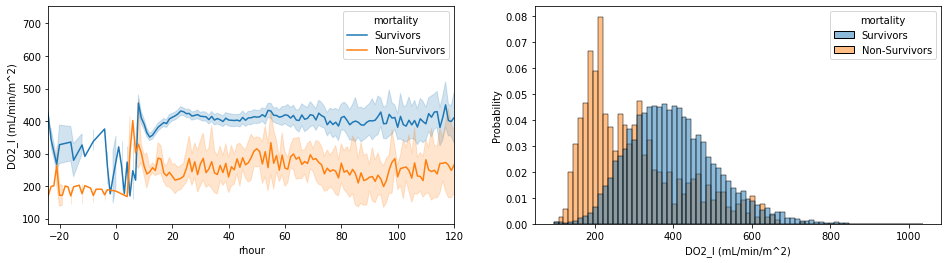

In [26]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
y='DO2_I'
y_u = y+' ({})'.format(OxygenDelivery.units[y])
dat = dat.rename(columns={y:y_u})
g = sns.lineplot(
    x='rhour',
    y=y_u,
    hue='mortality',data=dat, ax=axs[0])
g.set_xlim(-24,24*5)

sns.histplot(x=y_u, hue='mortality',data=dat.query('hour >= 18'),
         common_norm=False,stat='probability', ax=axs[1])

In [ ]:
asfd

In [ ]:
pc.offset

In [ ]:
f= tidy_flow(swan.flowsheet.sel(display_name=['CARDIAC OUTPUT','CCO'],encounter_id=eids))

In [ ]:
f['day'] = f.time / np.timedelta64(1,'D')

f['hour'] = (f.day*24).round().astype(int)
f['hour'] = pd.to_timedelta(f.hour-f.hour.min(), unit='hour')

In [ ]:
f.groupby(['encounter_id','hour','name']).mean()

In [ ]:
do.compute(100).head(100)

In [ ]:
class RespiratoryQuotient(Metric):
    REQUIRES = {
        'labs':['TCO2 VENOUS','TCO2 ARTERIAL','O2SAT ARTERIAL MEASURED','O2SAT VENOUS MEASURED'],
    }
    
    def requires(self):
        pass
    
rq = RespiratoryQuotient(db=swan, encounter_id=eids)

In [ ]:
rq.db_sample(2).groupby(['encounter_id','name']).mean()

In [ ]:
rq.db_fetch().encounter_id.unique()

In [ ]:
cao2 = OxygenContent(swan,encounter_id=eids)
# eids = cao2.db_fetch().encounter_id.drop_duplicates().sample(500)
# cao2 = OxygenContent(swan, encounter_id=eids)

In [ ]:
df = cao2.compute_oxygen_content_AV(sample=5, with_delivery=True)
# df['DO2'] = df.groupby(level='encounter_id').apply(lambda d: d.CaO2.interpolate()*d.CCO.interpolate()).values
df

In [ ]:
df_long = pd.melt(df.reset_index(),id_vars=['encounter_id','hour'],value_vars=['CCO','CaO2','CvO2','DO2'],var_name='name')

sns.catplot(col='name',x='hour',y='value',hue='name',data=df_long)

In [ ]:
from tricorder.cohort import ProcedureCohort

In [ ]:
swan.procedures.cohort(names=)

In [ ]:
pc.mortality

In [ ]:
ca = ca.merge(pc.mortality, on='encounter_id', how='left')

In [ ]:
tc = swan.labs.sel(lab_component_name=['TCO2 VENOUS','TCO2 ARTERIAL'], encounter_id=eids)

In [ ]:
tc = tidy_labs(tc)

In [ ]:
tc = tc.sort_values(['encounter_id','time'])
tc['hour'] = (tc.time/np.timedelta64(1,'D') * 24).round().astype(int)
tc['rhour'] = tc.groupby('encounter_id').apply(lambda d: d.hour - d.hour.min()).values

freqh = 12
bn = np.arange(-1,tc.rhour.max(),freqh)
labels = np.arange(freqh,tc.rhour.max(),freqh)
tc['rhour_b'] = pd.cut(tc.rhour,bins=bn,
                       labels=labels,
                      )
tc_pv = pd.pivot_table(index=['encounter_id','rhour_b'],values='value', aggfunc='mean', columns='name',data=tc)
tc_pv = tc_pv.reset_index()

In [ ]:
tc_pv.head()

In [ ]:
sns.lineplot(x='rhour_b',y='TCO2 ARTERIAL', data=tc_pv)

In [ ]:
tc_pv

In [ ]:
tc_pv = tc_pv.merge(pc.mortality, on='encounter_id', how='left')
sns.scatterplot(x='rhour_b',y='TCO2 ARTERIAL', hue='death',data=tc_pv)

In [ ]:
binned.query('name == "TCO2 VENOUS"')

In [ ]:
swan.labs.search('TC')

In [ ]:
swan.labs.search('BIC')

In [ ]:
sns.displot(col='death', x='value', hue='name',data=ca,)

In [ ]:
c2 = ca.set_index(pd.to_timedelta(ca.rday.values,unit='D')).sort_index()
c2

In [ ]:
c2['rday_b'] = pd.cut(c2.rday.values,np.arange(-0.5,c2.rday.round().max(),0.5),labels=False)

In [ ]:
enc = c2.encounter_id.drop_duplicates().sample(1)
dat=c2[c2.encounter_id.isin(enc)]
sns.scatterplot(x='rday_b',y='value',hue='name',data=dat)

In [ ]:
ca.groupby(['encounter_id','name']).count()

In [ ]:
ca.groupby('encounter_id').count()

In [ ]:
cao2.db_fetch().name.value_counts()

In [ ]:
df = cao2.db_fetch(sample=1)

In [ ]:
df[df.name.str.contains('HEMOGLOBIN')]

In [ ]:
df.name.unique()

In [ ]:
cao2.db_fetch().groupby(['encounter_id','time','name']).count()

In [ ]:
l_e = swan.labs.sel(lab_component_name=cao2.lab_names).encounter_id.unique()

In [ ]:
f_e = swan.flowsheet.sel(display_name=['CCI']).encounter_id.unique()

In [ ]:
len(np.intersect1d(l_e,f_e))

In [ ]:
swan.labs.search('O2')

In [ ]:
eids = hgb.encounter_id.value_counts().index.intersection(sao2.encounter_id.value_counts().index)

In [ ]:
sao2.encounter_id.value_counts()

In [ ]:
sao2 = swan.labs.sel(lab_component_name=['FIO2','O2SAT ARTERIAL MEASURED'])
sao2
# sao2.query('encounter_id == 169906456092')

In [ ]:
sns.lineplot(
#     x='lab_collection_days_since_birth',
    x='hours',
    y='value',hue='name',data=hgb.query('encounter_id == 169906456092'))

In [ ]:
hgb.groupby('lab_component_name').count()

In [ ]:
swan.labs.unique().tolist()

In [ ]:
swan.flowsheet.search('O2')

In [ ]:
swan.flowsheet.sel(display_name=['PAP'])